In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
import numpy as np

from sklearn.model_selection import train_test_split
from statsmodels.imputation import mice

In [3]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [4]:
missing_data = dataset.isna().sum().sort_values()
missing_data

RID                            0
Gender                         0
Ageatscreening                 0
Diagnosis                      0
HipsSumAveragebaseline         1
MMSE0m                         3
ERCsASMbaseline                4
HipsSumVariancebaseline        7
HipsVariancebaseline           8
ERCsEntropybaseline            9
ERCsSumAveragebaseline        11
ERCsSumVariancebaseline       13
ERCsVariancebaseline          14
HipsContrastbaseline          14
ERCsVolumebaseline            14
ERCsContrastbaseline          18
HipsClusterShadebaseline      18
HipposcampusVolumebaseline    19
HipsCorelationbaseline        20
HipsEntropybaseline           23
HipsASMbaseline               25
ERCsCorelationbaseline        28
ERCsClusterShadebaseline      34
ERCs_thicknessbaseline        37
dtype: int64

In [5]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [6]:
def ppm_imputation(num_iter, X_train, X_test):

    # Store the imputations
    imputed_datasets_train = []

    # Loop for imputations
    for i in range(num_iter):
        mice_data = mice.MICEData(X_train, 
                                perturbation_method='gaussian', 
                                k_pmm=20, 
                                history_callback=None)
        mice_data.update_all()
        imputed_datasets_train.append(mice_data.data)

    # Average the imputed datasets
    X_train_imputed = np.mean(imputed_datasets_train, axis=0)

    # Repeat for the test dataset
    imputed_datasets_test = []
    for i in range(num_iter):
        mice_data_test = mice.MICEData(X_test, 
                                    perturbation_method='gaussian', 
                                    k_pmm=20, 
                                    history_callback=None)
        mice_data_test.update_all()
        imputed_datasets_test.append(mice_data_test.data)

    X_test_imputed = np.mean(imputed_datasets_test, axis=0)
    
    return X_train_imputed, X_test_imputed

In [7]:
X_train_imputed_5, X_test_imputed_5 = ppm_imputation(5, X_train, X_test)
X_train_imputed_10, X_test_imputed_10 = ppm_imputation(10, X_train, X_test)
X_train_imputed_15, X_test_imputed_15 = ppm_imputation(15, X_train, X_test)
X_train_imputed_50, X_test_imputed_50 = ppm_imputation(50, X_train, X_test)

In [10]:
X_train_imputed_5 = pd.DataFrame(X_train_imputed_5, columns=X_train.columns)
X_test_imputed_5 = pd.DataFrame(X_test_imputed_5, columns=X_test.columns)

X_train_imputed_10 = pd.DataFrame(X_train_imputed_10, columns=X_train.columns)
X_test_imputed_10 = pd.DataFrame(X_test_imputed_10, columns=X_test.columns)

X_train_imputed_15 = pd.DataFrame(X_train_imputed_15, columns=X_train.columns)
X_test_imputed_15 = pd.DataFrame(X_test_imputed_15, columns=X_test.columns)

X_train_imputed_50 = pd.DataFrame(X_train_imputed_50, columns=X_train.columns)
X_test_imputed_50 = pd.DataFrame(X_test_imputed_50, columns=X_test.columns)

In [11]:
dataframes = [
    X_train_imputed_5, X_test_imputed_5, 
    X_train_imputed_10, X_test_imputed_10,
    X_train_imputed_15, X_test_imputed_15,
    X_train_imputed_50, X_test_imputed_50,
]

for df in dataframes:
    if df.isna().any().all() == False:
        print("No missing values in any dataframe")
        break
    else:
        print("Still missing values")

No missing values in any dataframe


### Check for normal distribution and skewness change 

In [63]:
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis

def check_normality(dataset):
    
    results = {}

    for column in dataset.columns:  
        stat, p = shapiro(dataset[column].dropna())
        skewness = skew(dataset[column].dropna())
        kurt = kurtosis(dataset[column].dropna())
        results[column] = {'Statistic': stat, 'p-value': p, 'Skewness': skewness, 'Kurtosis': kurt, 'Normal': p > 0.05} 

    # Convert results to DataFrame for better visualization
    results_df = pd.DataFrame(results).T
    return results_df

In [48]:
X_train_norm = check_normality(X_train)
X_test_norm = check_normality(X_test)

X_train_norm_5 = check_normality(X_train_imputed_5)
X_test_norm_5 = check_normality(X_test_imputed_5)

X_train_norm_10 = check_normality(X_train_imputed_10)
X_test_norm_10 = check_normality(X_test_imputed_10)

X_train_norm_15 = check_normality(X_train_imputed_15)
X_test_norm_15 = check_normality(X_test_imputed_15)

X_train_norm_50 = check_normality(X_train_imputed_50)
X_test_norm_50 = check_normality(X_test_imputed_50)

In [49]:
X_train_norm

,Statistic,p-value,Skewness,Kurtosis,Normal
RID,0.960571,0.0,-0.191996,-1.042352,False
Gender,0.629481,0.0,0.280362,-1.921397,False
Ageatscreening,0.98636,0.000507,-0.352696,0.074891,False
MMSE0m,0.899325,0.0,-0.86101,0.089239,False
HipsASMbaseline,0.962064,0.0,0.527045,-0.234448,False
HipsContrastbaseline,0.991863,0.022984,0.21891,-0.294576,False
HipsCorelationbaseline,0.973015,0.000001,-0.465003,-0.239129,False
HipsVariancebaseline,0.93952,0.0,-0.707282,-0.345891,False
HipsSumAveragebaseline,0.992093,0.023528,-0.087851,-0.465718,False
HipsSumVariancebaseline,0.93146,0.0,-0.775533,-0.258937,False


In [16]:
normal_train_df = pd.DataFrame({"X_train_norm": X_train_norm["Normal"],
                                "X_train_norm_5": X_train_norm_5["Normal"],
                                "X_train_norm_10": X_train_norm_10["Normal"],
                                "X_train_norm_15": X_train_norm_15["Normal"],
                                "X_train_norm_50": X_train_norm_50["Normal"],
})

normal_test_df = pd.DataFrame({"X_test_norm": X_test_norm["Normal"],
                               "X_test_norm_5": X_test_norm_5["Normal"],
                               "X_test_norm_10": X_test_norm_10["Normal"],
                               "X_test_norm_15": X_test_norm_15["Normal"],
                               "X_test_norm_50": X_test_norm_50["Normal"]
})

In [17]:
normal_train_df

,X_train_norm,X_train_norm_5,X_train_norm_10,X_train_norm_15,X_train_norm_50
RID,False,False,False,False,False
Gender,False,False,False,False,False
Ageatscreening,False,False,False,False,False
MMSE0m,False,False,False,False,False
HipsASMbaseline,False,False,False,False,False
HipsContrastbaseline,False,False,False,False,False
HipsCorelationbaseline,False,False,False,False,False
HipsVariancebaseline,False,False,False,False,False
HipsSumAveragebaseline,False,False,False,False,False
HipsSumVariancebaseline,False,False,False,False,False


In [18]:
print("Total normal distribution count for X_train_norm")
print(normal_train_df["X_train_norm"].value_counts())

print("Total normal distribution count for X_train_norm_5")
print(normal_train_df["X_train_norm_5"].value_counts())

print("Total normal distribution count for X_train_norm_10")
print(normal_train_df["X_train_norm_10"].value_counts())

print("Total normal distribution count for X_train_norm_15")
print(normal_train_df["X_train_norm_15"].value_counts())

print("Total normal distribution count for X_train_norm_50")
print(normal_train_df["X_train_norm_50"].value_counts())

Total normal distribution count for X_train_norm
X_train_norm
False    20
True      3
Name: count, dtype: int64
Total normal distribution count for X_train_norm_5
X_train_norm_5
False    20
True      3
Name: count, dtype: int64
Total normal distribution count for X_train_norm_10
X_train_norm_10
False    20
True      3
Name: count, dtype: int64
Total normal distribution count for X_train_norm_15
X_train_norm_15
False    20
True      3
Name: count, dtype: int64
Total normal distribution count for X_train_norm_50
X_train_norm_50
False    20
True      3
Name: count, dtype: int64


In [19]:
normal_test_df

,X_test_norm,X_test_norm_5,X_test_norm_10,X_test_norm_15,X_test_norm_50
RID,False,False,False,False,False
Gender,False,False,False,False,False
Ageatscreening,False,False,False,False,False
MMSE0m,False,False,False,False,False
HipsASMbaseline,False,False,False,False,False
HipsContrastbaseline,True,True,True,True,True
HipsCorelationbaseline,False,False,False,False,False
HipsVariancebaseline,False,False,False,False,False
HipsSumAveragebaseline,False,False,False,False,False
HipsSumVariancebaseline,False,False,False,False,False


In [20]:
print("\nTotal normal distribution count for X_train_norm")
print(normal_test_df["X_test_norm"].value_counts())

print("\nTotal normal distribution count for X_test_norm_5")
print(normal_test_df["X_test_norm_5"].value_counts())

print("\nTotal normal distribution count for X_test_norm_10")
print(normal_test_df["X_test_norm_10"].value_counts())

print("\nTotal normal distribution count for X_test_norm_15")
print(normal_test_df["X_test_norm_15"].value_counts())

print("\nTotal normal distribution count for X_test_norm_50")
print(normal_test_df["X_test_norm_50"].value_counts())


Total normal distribution count for X_train_norm
X_test_norm
False    13
True     10
Name: count, dtype: int64

Total normal distribution count for X_test_norm_5
X_test_norm_5
False    13
True     10
Name: count, dtype: int64

Total normal distribution count for X_test_norm_10
X_test_norm_10
False    13
True     10
Name: count, dtype: int64

Total normal distribution count for X_test_norm_15
X_test_norm_15
False    13
True     10
Name: count, dtype: int64

Total normal distribution count for X_test_norm_50
X_test_norm_50
False    13
True     10
Name: count, dtype: int64


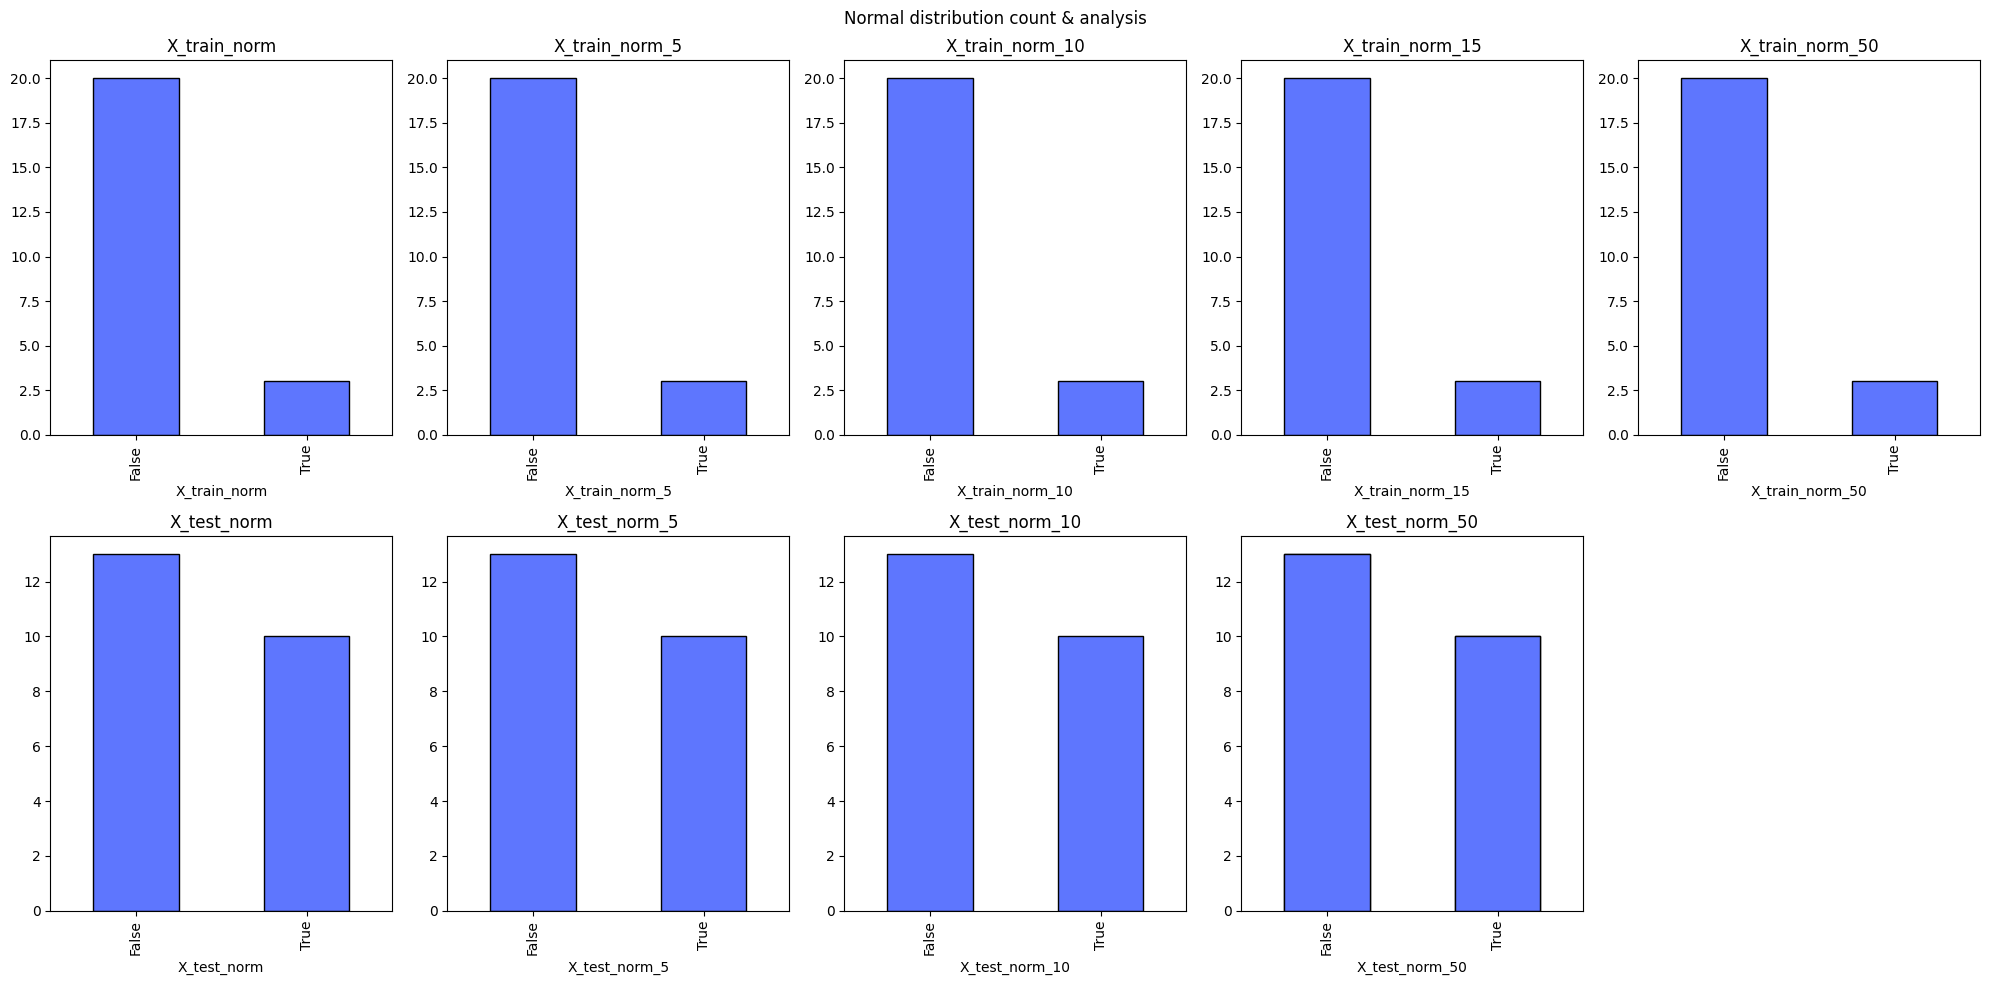

In [26]:
plt.figure(figsize=(20,10))
plt.suptitle("Normal distribution count & analysis")

plt.subplot(2, 5, 1)
normal_train_df["X_train_norm"].value_counts().plot(kind="bar",
                                             color = "#5e76fe",
                                             edgecolor = "black",
                                             label = "X_train_norm")
plt.title("X_train_norm")

plt.subplot(2, 5, 2)
normal_train_df["X_train_norm_5"].value_counts().plot(kind="bar",
                                             color = "#5e76fe",
                                             edgecolor = "black",
                                             label = "X_train_norm")
plt.title("X_train_norm_5")

plt.subplot(2, 5, 3)
normal_train_df["X_train_norm_10"].value_counts().plot(kind="bar",
                                             color = "#5e76fe",
                                             edgecolor = "black",
                                             label = "X_train_norm")
plt.title("X_train_norm_10")


plt.subplot(2, 5, 4)
normal_train_df["X_train_norm_15"].value_counts().plot(kind="bar",
                                             color = "#5e76fe",
                                             edgecolor = "black",
                                             label = "X_train_norm")
plt.title("X_train_norm_15")

plt.subplot(2, 5, 5)
normal_train_df["X_train_norm_50"].value_counts().plot(kind="bar",
                                             color = "#5e76fe",
                                             edgecolor = "black",
                                             label = "X_train_norm")
plt.title("X_train_norm_50")

plt.subplot(2, 5, 6)
normal_test_df["X_test_norm"].value_counts().plot(kind="bar",
                                             color = "#5e76fe",
                                             edgecolor = "black",
                                             label = "X_test_norm")
plt.title("X_test_norm")

plt.subplot(2, 5, 7)
normal_test_df["X_test_norm_5"].value_counts().plot(kind="bar",
                                             color = "#5e76fe",
                                             edgecolor = "black",
                                             label = "X_test_norm")
plt.title("X_test_norm_5")

plt.subplot(2, 5, 8)
normal_test_df["X_test_norm_10"].value_counts().plot(kind="bar",
                                             color = "#5e76fe",
                                             edgecolor = "black",
                                             label = "X_test_norm")
plt.title("X_test_norm_10")

plt.subplot(2, 5, 9)
normal_test_df["X_test_norm_15"].value_counts().plot(kind="bar",
                                             color = "#5e76fe",
                                             edgecolor = "black",
                                             label = "X_test_norm")
plt.title("X_test_norm_15")

plt.subplot(2, 5, 9)
normal_test_df["X_test_norm_50"].value_counts().plot(kind="bar",
                                             color = "#5e76fe",
                                             edgecolor = "black",
                                             label = "X_test_norm")
plt.title("X_test_norm_50")

plt.tight_layout()

AttributeError: 'float' object has no attribute 'shape'

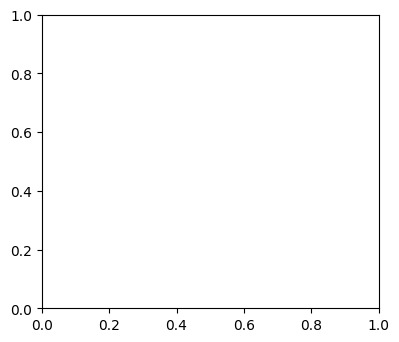

In [72]:
import scipy.stats as stats

# Plot Q-Q plots for each column
plt.figure(figsize=(20, 45))

for i in range(len(X_train_imputed_50.columns)):
    # Plot Q-Q for X_train_norm_5
    plt.subplot(10, 4, i * 3 + 1)  # Change the position for each plot
    stats.probplot(X_train_norm_5[X_train_norm_5.columns[i]], dist='norm', plot=plt)
    plt.title(f'{X_train_norm_5.columns[i]} - X_train_norm_5')

    # Plot Q-Q for X_train_imputed_10
    plt.subplot(10, 4, i * 3 + 2)  # Change the position for each plot
    stats.probplot(X_train_imputed_10[X_train_imputed_10.columns[i]], dist='norm', plot=plt)
    plt.title(f'{X_train_imputed_10.columns[i]} - X_train_imputed_10')

    # Plot Q-Q for X_train_imputed_50
    plt.subplot(10, 4, i * 3 + 3)  # Change the position for each plot
    stats.probplot(X_train_imputed_50[X_train_imputed_50.columns[i]], dist='norm', plot=plt)
    plt.title(f'{X_train_imputed_50.columns[i]} - X_train_imputed_50')

plt.tight_layout()
plt.show()

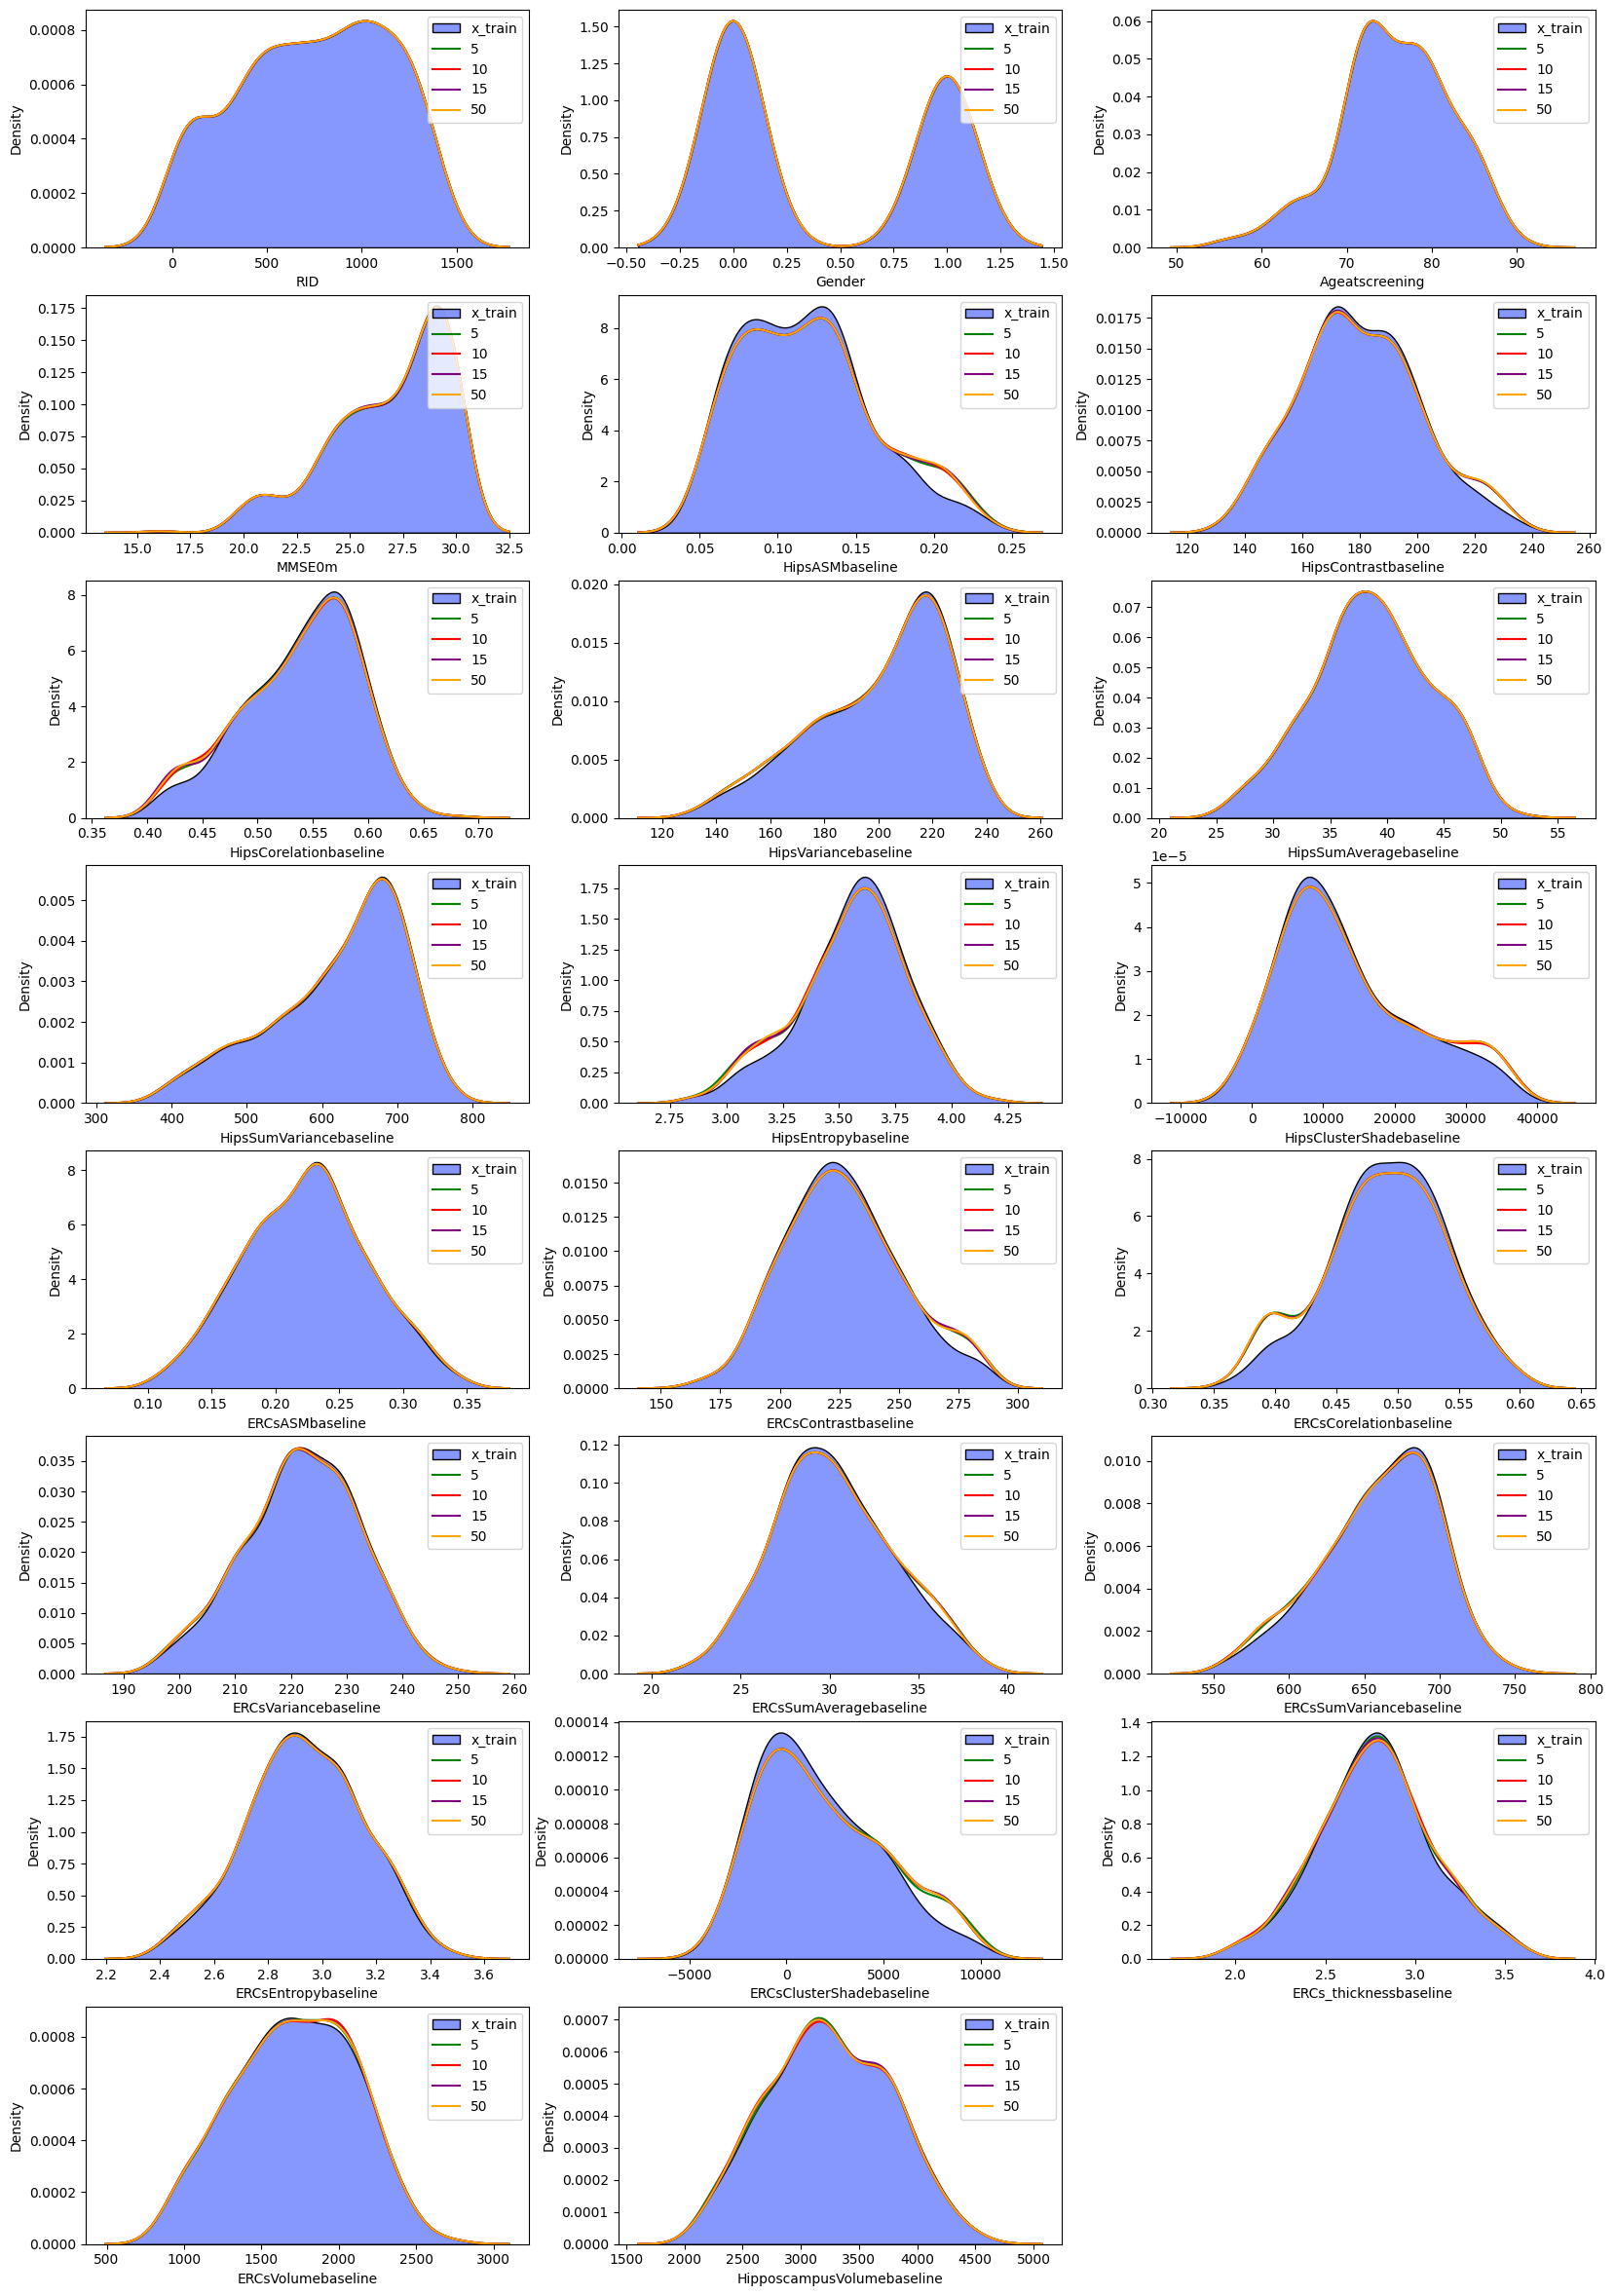

In [27]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_copy[X_train_copy.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_imputed_5[X_train_imputed_5.columns[i]], color= "green")
    
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_imputed_10[X_train_imputed_10.columns[i]], color= "red")
    
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_imputed_15[X_train_imputed_15.columns[i]], color= "purple")
    
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_imputed_50[X_train_imputed_50.columns[i]], color= "orange")
    
    labels = ['x_train', '5', '10', '15', '50']
    plt.legend(labels, loc='upper right')

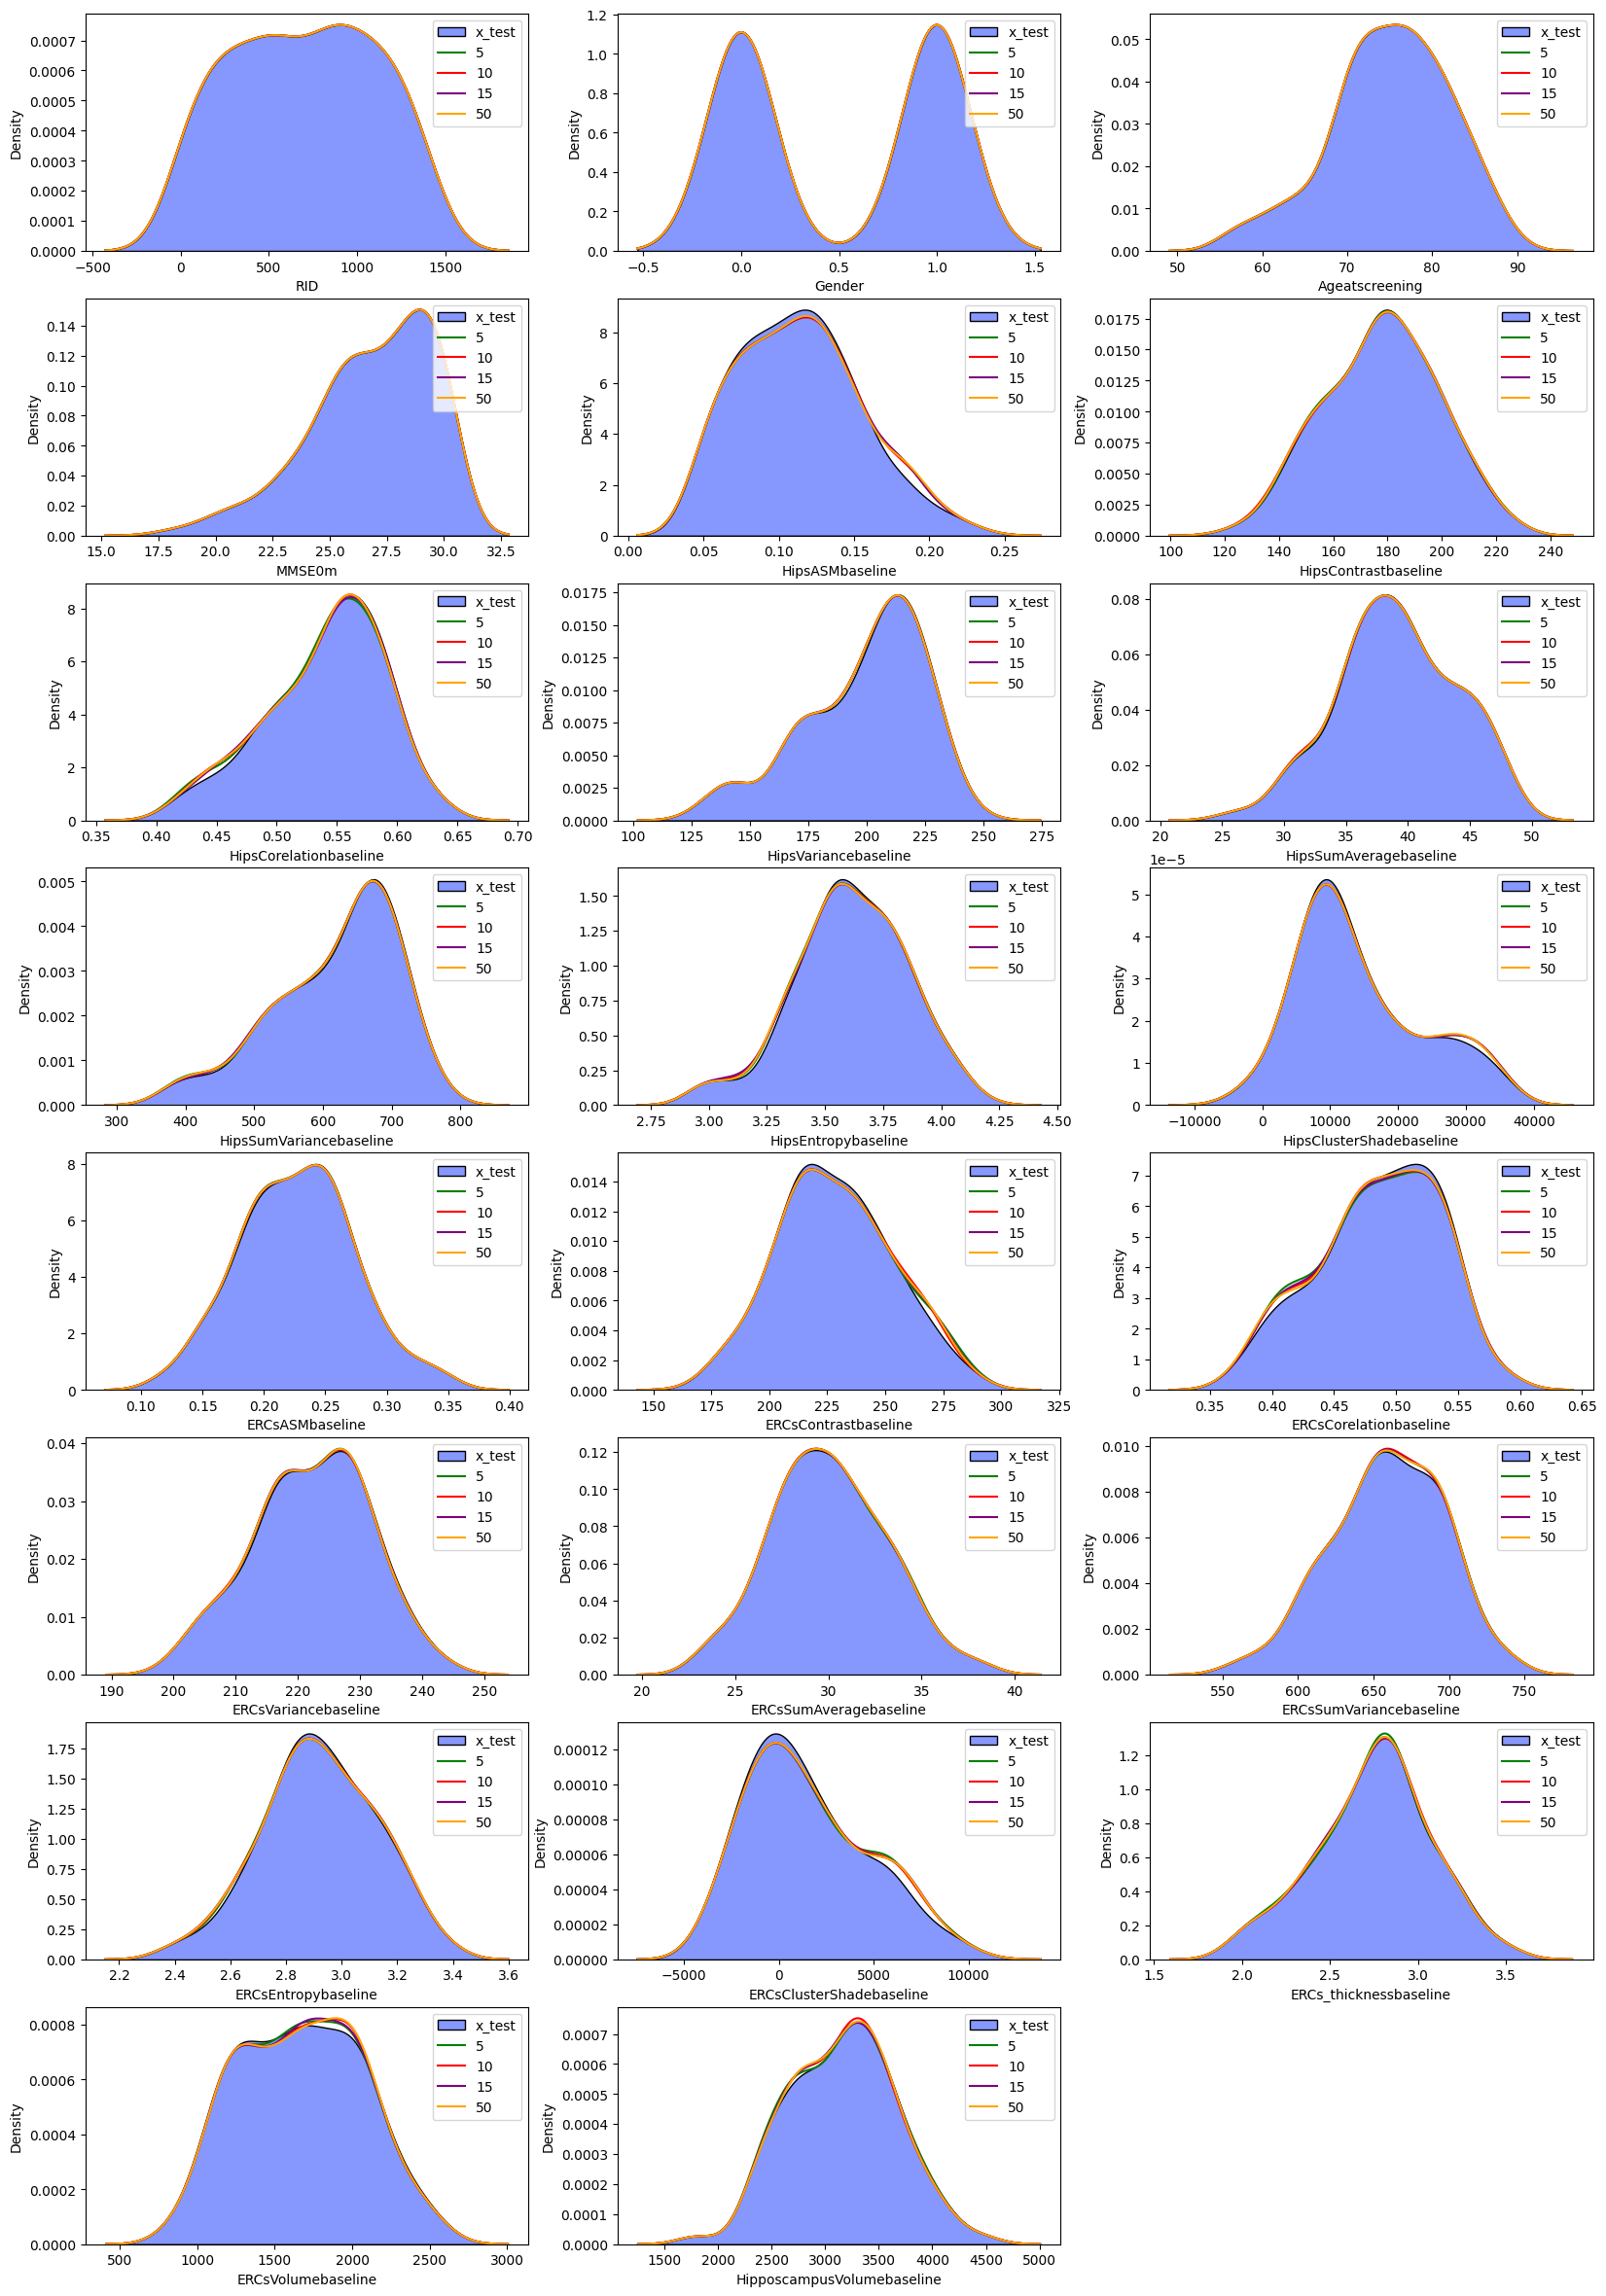

In [28]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_copy[X_test_copy.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_imputed_5[X_test_imputed_5.columns[i]], color= "green")
    
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_imputed_10[X_test_imputed_10.columns[i]], color= "red")
    
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_imputed_15[X_test_imputed_15.columns[i]], color= "purple")
    
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_imputed_50[X_test_imputed_50.columns[i]], color= "orange")
    
    labels = ['x_test', '5', '10', '15', '50']
    plt.legend(labels, loc='upper right')